In [1]:
# Local Interpretability: LIME and ICE Methods
# Implementation for LightGBM Model from Step2 (Exact Same Preprocessing)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import re
import json

# Import interpretability libraries
import lime
import lime.lime_tabular
import shap

# Import model libraries
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
import polars as pl

# Set style for plots
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

SEED = 42
np.random.seed(SEED)

print("Libraries loaded successfully!")


Libraries loaded successfully!


/Users/solalzana/Desktop/DSB - A2/Interpretability, Stability & Algorithmic Fairness/Algo_fairness-Group-Project/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# EXACT SAME PREPROCESSING AS STEP2
# Copy all preprocessing functions from Step2 to ensure identical model

pl.enable_string_cache()

# Constants from Step2
FORBID_COLS = {
    "unnamed_0", "predictions", "predicted_probabilities", "pct_afro_american", "zip_code"
}
TARGET_COL = "target"
TIME_COL = "issue_d"

CANDIDATE_COLS = [
    "issue_d","loan_duration","annual_inc","avg_cur_bal","bc_open_to_buy","bc_util",
    "delinq_2yrs","dti","emp_length","purpose","revol_bal","revol_util","sub_grade",
    "target","tax_liens","pct_afro_american","predictions","predicted_probabilities",
    "zip_code","unnamed_0"
]

CAST_MAP = {
    "issue_d": pl.Int32,
    "loan_duration": pl.Int8,
    "annual_inc": pl.Float32,
    "avg_cur_bal": pl.Float32,
    "bc_open_to_buy": pl.Float32,
    "bc_util": pl.Float32,
    "delinq_2yrs": pl.Int8,
    "dti": pl.Float32,
    "emp_length": pl.Utf8,
    "purpose": pl.Utf8,
    "revol_bal": pl.Float32,
    "revol_util": pl.Float32,
    "sub_grade": pl.Utf8,
    "target": pl.Int8,
    "tax_liens": pl.Int8,
    "zip_code": pl.Utf8,
    "pct_afro_american": pl.Float32,
    "predictions": pl.Int8,
    "predicted_probabilities": pl.Float32,
    "unnamed_0": pl.Int64
}

def to_snake(s: str) -> str:
    s = s.strip().replace("%","pct")
    s = re.sub(r"[^\w]+", "_", s)
    s = re.sub(r"_+", "_", s)
    return s.strip("_").lower()

def parse_emp_length(s: str) -> float:
    if s is None: return np.nan
    s = str(s).lower().strip()
    if s in ("n/a", "na", "nan", ""): return np.nan
    if "10+" in s: return 10.0
    m = re.search(r"(\d+)\s*years?", s)
    if m: return float(m.group(1))
    if "year" in s and re.search(r"\d", s) is None: return 1.0
    return np.nan

def subgrade_to_ordinal(s: str) -> int:
    if s is None: return -1
    s = str(s).strip().upper()
    if len(s) < 2: return -1
    letter = s[0]; num = s[1:]
    base = {"A":0,"B":5,"C":10,"D":15,"E":20,"F":25,"G":30}.get(letter, -5)
    try:
        return base + (int(num) - 1)
    except:
        return -1

def fe(df: pl.DataFrame) -> pl.DataFrame:
    """Feature engineering - exact copy from Step2"""
    d = df
    
    # 1) Parse emp_length → years
    if "emp_length" in d.columns:
        d = d.with_columns(
            pl.col("emp_length").map_elements(parse_emp_length, return_dtype=pl.Float32).alias("emp_len_years")
        )
    
    # 2) sub_grade A1..G5 → ordinal
    if "sub_grade" in d.columns:
        d = d.with_columns(
            pl.col("sub_grade").map_elements(subgrade_to_ordinal, return_dtype=pl.Int8).alias("sub_grade_ord")
        )
    
    # 3) Percentage fields → 0–1
    for col in ["revol_util", "bc_util"]:
        if col in d.columns:
            d = d.with_columns((pl.col(col) / 100.0).alias(col))
    
    # 4) Common constructed features
    if {"revol_bal", "annual_inc"} <= set(d.columns):
        d = d.with_columns(
            pl.when(pl.col("annual_inc") > 0)
              .then(pl.col("revol_bal") / pl.col("annual_inc"))
              .otherwise(None)
              .cast(pl.Float32)
              .alias("revol_to_inc")
        )
    
    if {"avg_cur_bal", "bc_open_to_buy"} <= set(d.columns):
        d = d.with_columns(
            pl.when(pl.col("bc_open_to_buy") + 1e-6 > 0)
              .then(pl.col("avg_cur_bal") / (pl.col("bc_open_to_buy") + 1e-6))
              .otherwise(None)
              .cast(pl.Float32)
              .alias("cur_to_openbuy")
        )
    
    if "annual_inc" in d.columns:
        d = d.with_columns(
            pl.when(pl.col("annual_inc") < 1)
              .then(1)
              .otherwise(pl.col("annual_inc"))
              .log()
              .alias("log_annual_inc")
        )
    
    if "dti" in d.columns:
        d = d.with_columns(
            pl.when(pl.col("dti") < 0)
              .then(0)
              .when(pl.col("dti") > 100)
              .then(100)
              .otherwise(pl.col("dti"))
              .alias("dti_clip")
        )
    
    # 5) Handle categorical missing values
    for c in ["purpose"]:
        if c in d.columns:
            d = d.with_columns(pl.col(c).fill_null("Unknown"))
    
    # 6) Drop forbidden columns
    keep = [c for c in d.columns if c not in FORBID_COLS]
    d = d.select(keep)
    
    return d

print("Preprocessing functions loaded (exact copy from Step2)")


Preprocessing functions loaded (exact copy from Step2)


In [3]:
# LOAD AND PREPROCESS DATA (EXACT SAME AS STEP2)

def scan_any(path: str) -> pl.LazyFrame:
    ext = os.path.splitext(path)[1].lower()
    if ext in [".csv", ".txt"]:
        return pl.scan_csv(path, ignore_errors=True, try_parse_dates=False, null_values=["", "NA", "NaN", "null"])
    elif ext in [".parquet", ".pq"]:
        return pl.scan_parquet(path)
    else:
        raise ValueError(f"Unsupported file: {path}")

def prepare_data(data_path):
    """Prepare data with exact same preprocessing as Step2"""
    # Load data
    lf = scan_any(data_path)
    cols_current = lf.columns
    rename_map = {c: to_snake(c) for c in cols_current}
    lf = lf.rename(rename_map)
    
    # Select candidate columns
    selected = [c for c in CANDIDATE_COLS if c in lf.columns]
    if not selected:
        selected = lf.columns
    lf = lf.select(selected)
    
    # Cast types
    casts = []
    for k, v in CAST_MAP.items():
        if k in lf.columns:
            casts.append(pl.col(k).cast(v, strict=False))
    if casts:
        lf = lf.with_columns(casts)
    
    # Split by time (same as Step2)
    if TIME_COL not in lf.columns:
        raise RuntimeError(f"Missing time column `{TIME_COL}` after normalization.")
    
    train_lazy = lf.filter(pl.col(TIME_COL) <= 2015)
    test_lazy = lf.filter(pl.col(TIME_COL) > 2015)
    
    # Apply feature engineering
    train_df = fe(train_lazy.collect())
    test_df = fe(test_lazy.collect())
    
    if TARGET_COL not in train_df.columns or TARGET_COL not in test_df.columns:
        raise RuntimeError(f"Missing target column `{TARGET_COL}` in data.")
    
    # Split training data into train/validation (same as Step2)
    years = sorted(train_df[TIME_COL].unique().to_list())
    max_year = years[-1]
    train_inner = train_df.filter(pl.col(TIME_COL) < max_year)
    valid_inner = train_df.filter(pl.col(TIME_COL) == max_year)
    
    # Convert to pandas for model training
    train_pd = train_inner.to_pandas()
    valid_pd = valid_inner.to_pandas()
    test_pd = test_df.to_pandas()
    
    # Light imputation (same as Step2)
    def light_impute(df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        for c in df.columns:
            if c == TARGET_COL: 
                continue
            if pd.api.types.is_numeric_dtype(df[c]):
                df[c] = df[c].astype("float32")
                if df[c].isna().any():
                    df[c] = df[c].fillna(df[c].median())
            else:
                df[c] = df[c].astype("object").fillna("Unknown")
        return df
    
    train_pd = light_impute(train_pd)
    valid_pd = light_impute(valid_pd)
    test_pd = light_impute(test_pd)
    
    print(f"Data loaded and preprocessed:")
    print(f"  Training: {len(train_pd)} samples")
    print(f"  Validation: {len(valid_pd)} samples") 
    print(f"  Test: {len(test_pd)} samples")
    print(f"  Features: {len([c for c in train_pd.columns if c != TARGET_COL])}")
    
    return train_pd, valid_pd, test_pd

# Load the data
data_path = "/Users/solalzana/Desktop/DSB - A2/Interpretability, Stability & Algorithmic Fairness/Algo_fairness-Group-Project/data/dataproject2025.csv"
train_df, valid_df, test_df = prepare_data(data_path)

# Show feature names (should match Step2 exactly)
feature_names = [c for c in train_df.columns if c != TARGET_COL]
print(f"\nFeature names: {feature_names}")
print(f"Target distribution in test set: {test_df[TARGET_COL].value_counts().sort_index()}")


/var/folders/1q/4p_js9jn14x3_527d5fmd8dr0000gn/T/ipykernel_19136/3010786212.py:16: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  cols_current = lf.columns
/var/folders/1q/4p_js9jn14x3_527d5fmd8dr0000gn/T/ipykernel_19136/3010786212.py:21: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  selected = [c for c in CANDIDATE_COLS if c in lf.columns]
/var/folders/1q/4p_js9jn14x3_527d5fmd8dr0000gn/T/ipykernel_19136/3010786212.py:29: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without

Data loaded and preprocessed:
  Training: 253015 samples
  Validation: 271416 samples
  Test: 561805 samples
  Features: 20

Feature names: ['issue_d', 'loan_duration', 'annual_inc', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'delinq_2yrs', 'dti', 'emp_length', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'tax_liens', 'emp_len_years', 'sub_grade_ord', 'revol_to_inc', 'cur_to_openbuy', 'log_annual_inc', 'dti_clip']
Target distribution in test set: target
0    437966
1    123839
Name: count, dtype: int64


In [4]:
# TRAIN LIGHTGBM MODEL (EXACT SAME AS STEP2)

def train_lightgbm_model(train_df, valid_df, test_df):
    """Train LightGBM model with exact same parameters as Step2"""
    
    # Prepare data
    y_tr = train_df[TARGET_COL].astype("int8")
    X_tr = train_df.drop(columns=[TARGET_COL])
    y_va = valid_df[TARGET_COL].astype("int8")
    X_va = valid_df.drop(columns=[TARGET_COL])
    y_te = test_df[TARGET_COL].astype("int8")
    X_te = test_df.drop(columns=[TARGET_COL])
    
    # Identify categorical columns
    cat_cols = [c for c in X_tr.columns if X_tr[c].dtype.name in ("object", "category")]
    for c in cat_cols:
        X_tr[c] = X_tr[c].astype("category")
        X_va[c] = X_va[c].astype("category")
        X_te[c] = X_te[c].astype("category")
    
    # Handle class imbalance
    pos = int(y_tr.sum())
    neg = int((y_tr == 0).sum())
    scale_pos_weight = max(1.0, neg / max(1, pos))
    
    # Best parameters from Step2 grid search
    best_params = {
        'bagging_fraction': 0.8,
        'feature_fraction': 1.0,
        'lambda_l1': 0.1,
        'lambda_l2': 0,
        'learning_rate': 0.01,
        'max_depth': 5,
        'num_leaves': 64
    }
    
    # Model parameters (same as Step2)
    params = {
        "objective": "binary",
        "metric": ["auc"],
        "learning_rate": 0.05,
        "num_leaves": 64,
        "max_depth": -1,
        "feature_fraction": 0.8,
        "bagging_fraction": 0.8,
        "bagging_freq": 1,
        "lambda_l1": 0.0,
        "lambda_l2": 0.0,
        "verbose": -1,
        "seed": SEED,
        "scale_pos_weight": scale_pos_weight
    }
    
    # Update with best parameters
    params.update(best_params)
    
    # Create datasets
    lgb_train = lgb.Dataset(X_tr, label=y_tr, categorical_feature=cat_cols, free_raw_data=True)
    lgb_valid = lgb.Dataset(X_va, label=y_va, categorical_feature=cat_cols, reference=lgb_train, free_raw_data=True)
    
    # Train model
    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=500,
        valid_sets=[lgb_train, lgb_valid],
        valid_names=["train", "valid"],
        callbacks=[lgb.early_stopping(50), lgb.log_evaluation(50)]
    )
    
    # Evaluate model
    va_prob = model.predict(X_va, num_iteration=model.best_iteration)
    te_prob = model.predict(X_te, num_iteration=model.best_iteration)
    
    va_auc = roc_auc_score(y_va, va_prob)
    te_auc = roc_auc_score(y_te, te_prob)
    
    print(f"\nModel Performance:")
    print(f"  Validation AUC: {va_auc:.4f}")
    print(f"  Test AUC: {te_auc:.4f}")
    
    return model, X_tr, X_va, X_te, y_tr, y_va, y_te

# Train the model
model, X_train, X_valid, X_test, y_train, y_valid, y_test = train_lightgbm_model(train_df, valid_df, test_df)

print(f"\nModel trained successfully!")
print(f"Features used: {list(X_test.columns)}")
print(f"Number of features: {len(X_test.columns)}")


Training until validation scores don't improve for 50 rounds
[50]	train's auc: 0.690969	valid's auc: 0.70643
[100]	train's auc: 0.692824	valid's auc: 0.707222
[150]	train's auc: 0.694378	valid's auc: 0.707789
[200]	train's auc: 0.695856	valid's auc: 0.708158
[250]	train's auc: 0.69728	valid's auc: 0.708348
[300]	train's auc: 0.698586	valid's auc: 0.708513
[350]	train's auc: 0.699893	valid's auc: 0.708572
[400]	train's auc: 0.701044	valid's auc: 0.708613
[450]	train's auc: 0.702228	valid's auc: 0.708654
[500]	train's auc: 0.703354	valid's auc: 0.708673
Did not meet early stopping. Best iteration is:
[493]	train's auc: 0.703197	valid's auc: 0.708675

Model Performance:
  Validation AUC: 0.7087
  Test AUC: 0.6868

Model trained successfully!
Features used: ['issue_d', 'loan_duration', 'annual_inc', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'delinq_2yrs', 'dti', 'emp_length', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'tax_liens', 'emp_len_years', 'sub_grade_ord', 'revol_to_inc',

In [5]:
# LIME IMPLEMENTATION
# Local Interpretable Model-agnostic Explanations

print("=" * 60)
print("LIME (Local Interpretable Model-agnostic Explanations)")
print("=" * 60)
print("""
LIME explains individual predictions by:
1. Perturbing the input around the instance of interest
2. Training a simple interpretable model on the perturbed data
3. Using the simple model to explain the complex model's prediction

Key advantages:
- Model-agnostic (works with any ML model)
- Provides local explanations for individual predictions
- Human-interpretable feature importance
""")

def create_lime_explainer(X_train, feature_names, class_names=['No Default', 'Default']):
    """Create LIME tabular explainer"""
    explainer = lime.lime_tabular.LimeTabularExplainer(
        X_train.values,
        feature_names=feature_names,
        class_names=class_names,
        mode='classification',
        discretize_continuous=True,
        random_state=SEED
    )
    return explainer

def explain_instance_lime(explainer, model, instance, num_features=10):
    """Explain a single instance using LIME"""
    explanation = explainer.explain_instance(
        instance.values,
        model.predict,  # Use predict for probabilities
        num_features=num_features,
        top_labels=2
    )
    return explanation

# First, let's examine the data types to understand the categorical feature issue
print(f"\nData types in X_train:")
for col in X_train.columns:
    dtype = X_train[col].dtype
    unique_vals = X_train[col].nunique()
    print(f"  {col}: {dtype} (unique values: {unique_vals})")
    if dtype == 'object' or dtype.name == 'category':
        print(f"    Sample values: {X_train[col].unique()[:5]}")

print(f"\nCategorical columns detected:")
categorical_cols = [col for col in X_train.columns if X_train[col].dtype in ['object', 'category']]
print(f"  {categorical_cols}")

# The issue is that LIME can't handle string categorical features directly
# We need to encode them numerically for LIME while keeping the original model intact

# Create a copy of the data with categorical features encoded for LIME
from sklearn.preprocessing import LabelEncoder

def prepare_data_for_lime(X_data):
    """Prepare data for LIME by encoding categorical features"""
    X_lime = X_data.copy()
    label_encoders = {}
    
    for col in categorical_cols:
        if col in X_lime.columns:
            le = LabelEncoder()
            # Fit on all unique values from training data
            le.fit(X_train[col].astype(str))
            # Transform the data
            X_lime[col] = le.transform(X_lime[col].astype(str))
            label_encoders[col] = le
    
    return X_lime, label_encoders

# Prepare encoded data for LIME
X_train_lime, label_encoders = prepare_data_for_lime(X_train)
X_test_lime, _ = prepare_data_for_lime(X_test)

print(f"\nData prepared for LIME:")
print(f"  Original categorical columns: {categorical_cols}")
print(f"  Encoded data shape: {X_train_lime.shape}")
print(f"  All columns now numeric: {X_train_lime.dtypes.apply(lambda x: x.kind in 'biufc').all()}")

# Create a wrapper function for the model that handles the encoding
def model_predict_wrapper(X_array):
    """Wrapper function that converts encoded LIME data back to original format for model prediction"""
    # Convert array back to DataFrame
    X_df = pd.DataFrame(X_array, columns=X_train_lime.columns)
    
    # Decode categorical features back to original format
    X_decoded = X_df.copy()
    for col in categorical_cols:
        if col in X_decoded.columns:
            # Convert back to original categorical values
            decoded_values = label_encoders[col].inverse_transform(X_decoded[col].astype(int))
            X_decoded[col] = decoded_values
    
    # Ensure same data types as original training data
    for col in X_decoded.columns:
        if col in categorical_cols:
            # Convert to category dtype (same as training preprocessing)
            X_decoded[col] = X_decoded[col].astype('category')
        else:
            X_decoded[col] = X_decoded[col].astype(X_train[col].dtype)
    
    # Get PROBABILITY predictions from the model (not binary predictions)
    # LIME requires probability scores, not class predictions
    probabilities = model.predict(X_decoded)
    
    # Return probabilities in the format LIME expects: [prob_class_0, prob_class_1]
    # Since LightGBM returns probability of positive class, we need to create both probabilities
    prob_positive = probabilities.reshape(-1, 1)  # Probability of class 1 (default)
    prob_negative = (1 - probabilities).reshape(-1, 1)  # Probability of class 0 (no default)
    
    # Stack them to create [n_samples, 2] array
    return np.hstack([prob_negative, prob_positive])

# Test the wrapper function
print(f"\nTesting model wrapper function...")

# Debug: Check the data types we're working with
print(f"  Training data categorical columns and their dtypes:")
for col in categorical_cols:
    print(f"    {col}: {X_train[col].dtype}")
    print(f"      Categories: {X_train[col].cat.categories[:5]}...")

print(f"\n  Test data categorical columns before conversion:")
for col in categorical_cols:
    print(f"    {col}: {X_test[col].dtype}")
    print(f"      Sample values: {X_test[col].unique()[:5]}")

# Let's test the model prediction with a simple approach
# Use the same data preparation as in the training phase
print(f"\n  Testing direct model prediction...")
try:
    # Create a small test sample with proper preprocessing
    test_sample = X_test.iloc[:2].copy()
    
    # Apply the same categorical conversion as used in training
    for col in categorical_cols:
        if col in test_sample.columns:
            test_sample[col] = test_sample[col].astype('category')
    
    print(f"    Test sample dtypes after conversion:")
    for col in categorical_cols:
        print(f"      {col}: {test_sample[col].dtype}")
    
    # Test prediction using DataFrame (not .values)
    pred_result = model.predict(test_sample)
    print(f"    ✓ Direct prediction successful: {pred_result}")
    
    # Now test the wrapper function
    print(f"\n  Testing wrapper function...")
    wrapper_result = model_predict_wrapper(X_test_lime.iloc[:2].values)
    print(f"    ✓ Wrapper prediction successful: {wrapper_result}")
    print(f"    Wrapper result shape: {wrapper_result.shape}")
    print(f"    Wrapper result format: [prob_no_default, prob_default]")
    
    # Check that probabilities sum to 1
    prob_sums = wrapper_result.sum(axis=1)
    print(f"    Probability sums: {prob_sums} (should be close to 1.0)")
    
    # Compare positive class probabilities (column 1 of wrapper vs direct prediction)
    print(f"    Direct predictions: {pred_result}")
    print(f"    Wrapper positive class probs: {wrapper_result[:, 1]}")
    print(f"    Positive class predictions match: {np.allclose(pred_result, wrapper_result[:, 1])}")
    
except Exception as e:
    print(f"    ❌ Error in testing: {str(e)}")
    print(f"    Error type: {type(e).__name__}")
    import traceback
    traceback.print_exc()

# Create LIME explainer with encoded data
lime_explainer = create_lime_explainer(X_train_lime, list(X_train_lime.columns))
print(f"\nLIME explainer created successfully with encoded data!")
print(f"Training data shape: {X_train_lime.shape}")
print(f"Features: {list(X_train_lime.columns)}")

# Select diverse instances for explanation
np.random.seed(SEED)
n_instances = 5

# Get instances with different prediction probabilities
# Prepare test data for prediction (same as training preprocessing)
X_test_for_pred = X_test.copy()
for col in categorical_cols:
    if col in X_test_for_pred.columns:
        X_test_for_pred[col] = X_test_for_pred[col].astype('category')

test_probs = model.predict(X_test_for_pred)
prob_ranges = [(0.0, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, 1.0)]
selected_indices = []

for low, high in prob_ranges:
    mask = (test_probs >= low) & (test_probs < high)
    candidates = np.where(mask)[0]
    if len(candidates) > 0:
        selected_indices.append(np.random.choice(candidates))

# If we don't have enough diverse instances, add random ones
while len(selected_indices) < n_instances:
    idx = np.random.randint(0, len(X_test))
    if idx not in selected_indices:
        selected_indices.append(idx)

selected_indices = selected_indices[:n_instances]

print(f"\nSelected {len(selected_indices)} instances for LIME explanation:")
for i, idx in enumerate(selected_indices):
    prob = test_probs[idx]
    actual = y_test.iloc[idx]
    print(f"  Instance {i+1} (index {idx}): Predicted prob = {prob:.3f}, Actual = {actual}")

# Test LIME with a single instance first
print(f"\nTesting LIME with single instance...")
try:
    test_idx = selected_indices[0]
    print(f"  Testing with instance {test_idx}...")
    
    # Test the wrapper function format
    single_pred = model_predict_wrapper(X_test_lime.iloc[test_idx:test_idx+1].values)
    print(f"  Single prediction shape: {single_pred.shape}")
    print(f"  Single prediction values: {single_pred}")
    
    # Test LIME explanation
    test_explanation = lime_explainer.explain_instance(
        X_test_lime.iloc[test_idx].values,
        model_predict_wrapper,
        num_features=5,
        top_labels=1
    )
    print(f"  ✓ LIME test successful!")
    
    # Show test explanation
    exp_list = test_explanation.as_list(label=1)
    print(f"  Test explanation (top 3 features):")
    for j, (feature, weight) in enumerate(exp_list[:3]):
        print(f"    {j+1}. {feature}: {weight:.4f}")
        
except Exception as e:
    print(f"  ❌ LIME test failed: {str(e)}")
    import traceback
    traceback.print_exc()

# Generate LIME explanations using encoded data and wrapper function
print(f"\nGenerating LIME explanations...")
lime_explanations = []

try:
    for i, idx in enumerate(selected_indices):
        print(f"  Processing instance {i+1}/{len(selected_indices)} (index {idx})...")
        
        # Use encoded test data for LIME
        explanation = lime_explainer.explain_instance(
            X_test_lime.iloc[idx].values,
            model_predict_wrapper,
            num_features=10,
            top_labels=2
        )
        lime_explanations.append((idx, explanation))
        print(f"    ✓ Successfully generated explanation for instance {i+1}")
    
    print(f"\n✅ Generated {len(lime_explanations)} LIME explanations successfully!")
    
    # Show a sample explanation
    if lime_explanations:
        sample_idx, sample_exp = lime_explanations[0]
        print(f"\nSample explanation for instance {sample_idx}:")
        exp_list = sample_exp.as_list(label=1)
        for j, (feature, weight) in enumerate(exp_list[:5]):
            print(f"  {j+1}. {feature}: {weight:.4f}")
            
except Exception as e:
    print(f"\n❌ Error generating LIME explanations: {str(e)}")
    print(f"Error type: {type(e).__name__}")
    import traceback
    traceback.print_exc()


LIME (Local Interpretable Model-agnostic Explanations)

LIME explains individual predictions by:
1. Perturbing the input around the instance of interest
2. Training a simple interpretable model on the perturbed data
3. Using the simple model to explain the complex model's prediction

Key advantages:
- Model-agnostic (works with any ML model)
- Provides local explanations for individual predictions
- Human-interpretable feature importance


Data types in X_train:
  issue_d: float32 (unique values: 3)
  loan_duration: float32 (unique values: 2)
  annual_inc: float32 (unique values: 18505)
  avg_cur_bal: float32 (unique values: 50843)
  bc_open_to_buy: float32 (unique values: 40273)
  bc_util: float32 (unique values: 1001)
  delinq_2yrs: float32 (unique values: 19)
  dti: float32 (unique values: 3995)
  emp_length: category (unique values: 11)
    Sample values: ['2 years', '10+ years', '5 years', '6 years', '4 years']
Categories (11, object): ['1 year', '10+ years', '2 years', '3 years',

Traceback (most recent call last):
  File "/var/folders/1q/4p_js9jn14x3_527d5fmd8dr0000gn/T/ipykernel_19136/1194921877.py", line 237, in <module>
    exp_list = test_explanation.as_list(label=1)
  File "/Users/solalzana/Desktop/DSB - A2/Interpretability, Stability & Algorithmic Fairness/Algo_fairness-Group-Project/venv/lib/python3.13/site-packages/lime/explanation.py", line 141, in as_list
    ans = self.domain_mapper.map_exp_ids(self.local_exp[label_to_use], **kwargs)
                                         ~~~~~~~~~~~~~~^^^^^^^^^^^^^^
KeyError: 1



LIME EXPLANATION VISUALIZATIONS

--- LIME Explanation 1: Instance 212764 ---


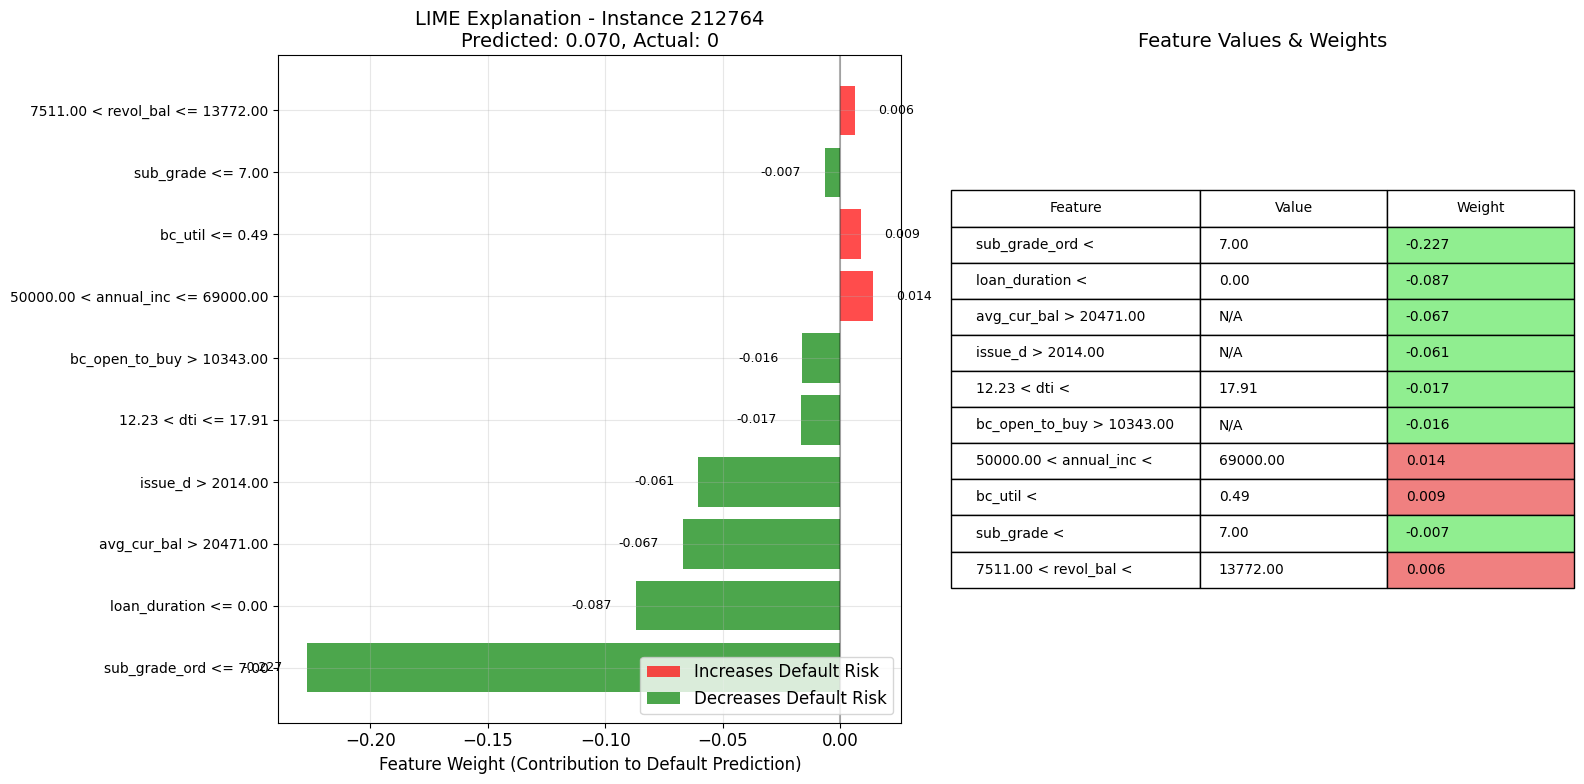


Text Summary for Instance 212764:
  Predicted Probability: 0.0702
  Actual Label: 0
  Prediction: No Default

Top 5 Contributing Features:
  1. sub_grade_ord <= 7.00: -0.2272 (decreases default risk)
  2. loan_duration <= 0.00: -0.0871 (decreases default risk)
  3. avg_cur_bal > 20471.00: -0.0672 (decreases default risk)
  4. issue_d > 2014.00: -0.0607 (decreases default risk)
  5. 12.23 < dti <= 17.91: -0.0169 (decreases default risk)
------------------------------------------------------------

--- LIME Explanation 2: Instance 395863 ---


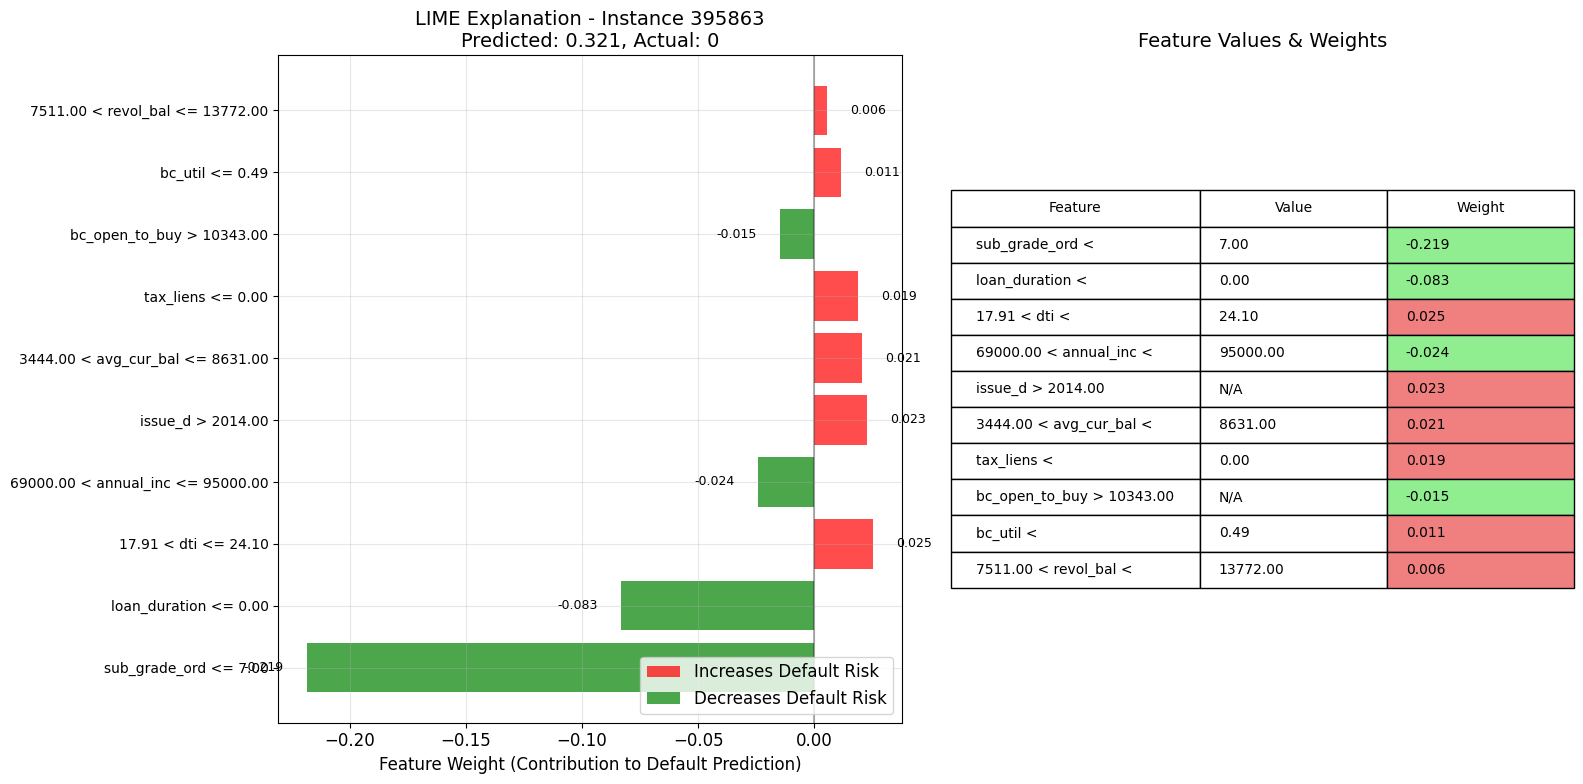


Text Summary for Instance 395863:
  Predicted Probability: 0.3210
  Actual Label: 0
  Prediction: No Default

Top 5 Contributing Features:
  1. sub_grade_ord <= 7.00: -0.2187 (decreases default risk)
  2. loan_duration <= 0.00: -0.0834 (decreases default risk)
  3. 17.91 < dti <= 24.10: 0.0255 (increases default risk)
  4. 69000.00 < annual_inc <= 95000.00: -0.0242 (decreases default risk)
  5. issue_d > 2014.00: 0.0227 (increases default risk)
------------------------------------------------------------

--- LIME Explanation 3: Instance 243721 ---


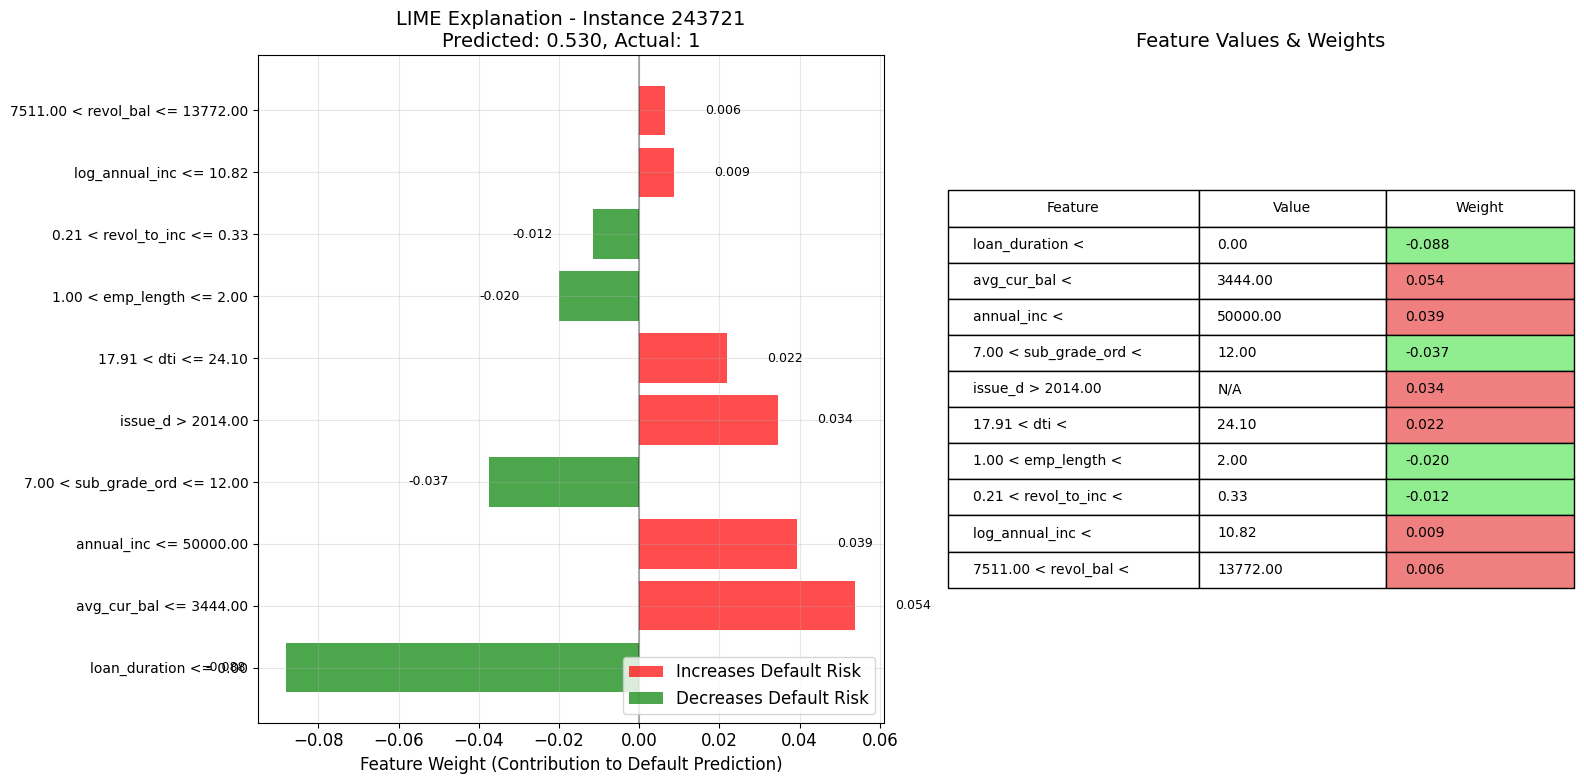


Text Summary for Instance 243721:
  Predicted Probability: 0.5300
  Actual Label: 1
  Prediction: Default

Top 5 Contributing Features:
  1. loan_duration <= 0.00: -0.0880 (decreases default risk)
  2. avg_cur_bal <= 3444.00: 0.0539 (increases default risk)
  3. annual_inc <= 50000.00: 0.0394 (increases default risk)
  4. 7.00 < sub_grade_ord <= 12.00: -0.0375 (decreases default risk)
  5. issue_d > 2014.00: 0.0345 (increases default risk)
------------------------------------------------------------

--- LIME Explanation 4: Instance 487322 ---


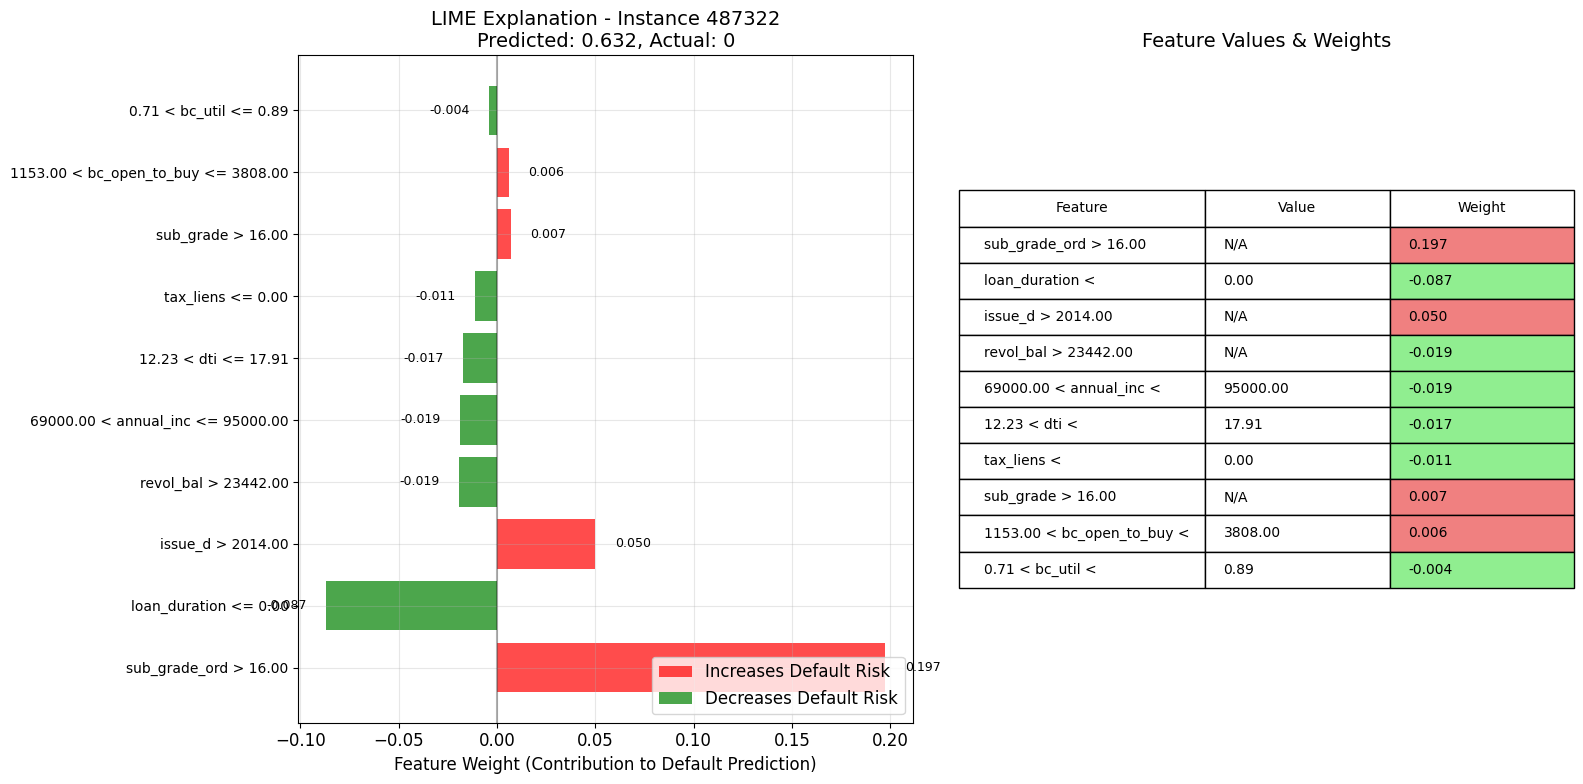


Text Summary for Instance 487322:
  Predicted Probability: 0.6319
  Actual Label: 0
  Prediction: Default

Top 5 Contributing Features:
  1. sub_grade_ord > 16.00: 0.1975 (increases default risk)
  2. loan_duration <= 0.00: -0.0869 (decreases default risk)
  3. issue_d > 2014.00: 0.0499 (increases default risk)
  4. revol_bal > 23442.00: -0.0191 (decreases default risk)
  5. 69000.00 < annual_inc <= 95000.00: -0.0187 (decreases default risk)
------------------------------------------------------------

--- LIME Explanation 5: Instance 512673 ---


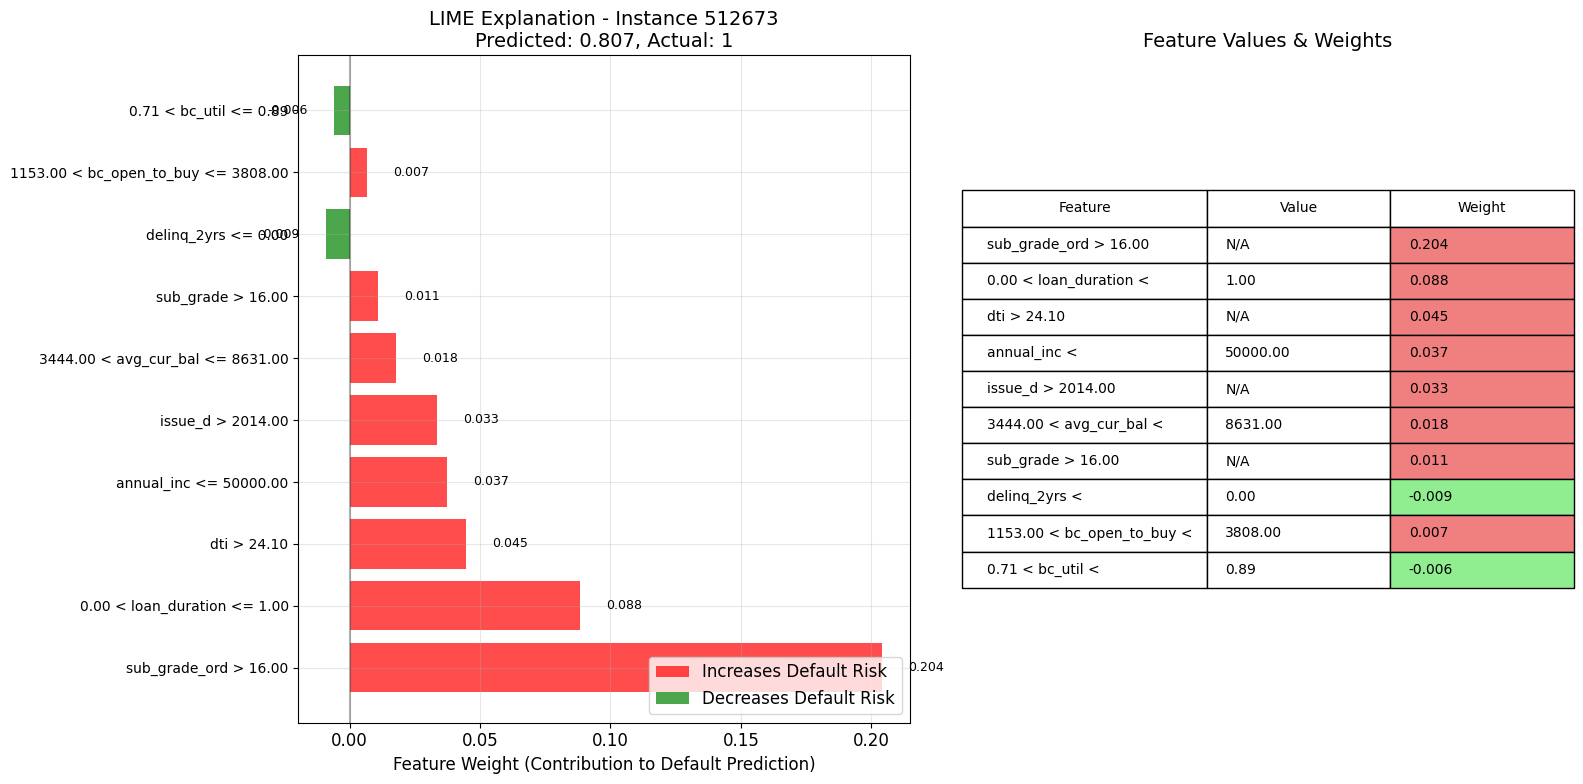


Text Summary for Instance 512673:
  Predicted Probability: 0.8069
  Actual Label: 1
  Prediction: Default

Top 5 Contributing Features:
  1. sub_grade_ord > 16.00: 0.2043 (increases default risk)
  2. 0.00 < loan_duration <= 1.00: 0.0883 (increases default risk)
  3. dti > 24.10: 0.0445 (increases default risk)
  4. annual_inc <= 50000.00: 0.0374 (increases default risk)
  5. issue_d > 2014.00: 0.0335 (increases default risk)
------------------------------------------------------------


In [6]:
# VISUALIZE LIME EXPLANATIONS

def plot_lime_explanation(explanation, instance_idx, actual_label, predicted_prob, save_fig=False):
    """Plot LIME explanation with enhanced visualization"""
    
    # Get explanation for the positive class (Default = 1)
    exp_list = explanation.as_list(label=1)
    
    # Extract features and weights
    features = [item[0] for item in exp_list]
    weights = [item[1] for item in exp_list]
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Left plot: Feature importance
    colors = ['red' if w > 0 else 'green' for w in weights]
    bars = ax1.barh(range(len(features)), weights, color=colors, alpha=0.7)
    
    ax1.set_yticks(range(len(features)))
    ax1.set_yticklabels(features, fontsize=10)
    ax1.set_xlabel('Feature Weight (Contribution to Default Prediction)', fontsize=12)
    ax1.set_title(f'LIME Explanation - Instance {instance_idx}\nPredicted: {predicted_prob:.3f}, Actual: {actual_label}', fontsize=14)
    ax1.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    ax1.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, (bar, weight) in enumerate(zip(bars, weights)):
        ax1.text(weight + (0.01 if weight > 0 else -0.01), i, f'{weight:.3f}', 
                va='center', ha='left' if weight > 0 else 'right', fontsize=9)
    
    # Right plot: Feature values for this instance
    instance_values = []
    feature_names_clean = []
    
    for feature in features:
        # Extract the actual feature value from the explanation text
        if '=' in feature:
            feature_name = feature.split('=')[0].strip()
            feature_value = feature.split('=')[1].strip()
        else:
            feature_name = feature
            feature_value = "N/A"
        
        feature_names_clean.append(feature_name)
        instance_values.append(feature_value)
    
    # Create a table-like visualization for feature values
    ax2.axis('off')
    table_data = []
    for i, (fname, fval, weight) in enumerate(zip(feature_names_clean, instance_values, weights)):
        color = 'lightcoral' if weight > 0 else 'lightgreen'
        table_data.append([fname, fval, f'{weight:.3f}'])
    
    table = ax2.table(cellText=table_data,
                     colLabels=['Feature', 'Value', 'Weight'],
                     cellLoc='left',
                     loc='center',
                     colWidths=[0.4, 0.3, 0.3])
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    
    # Color code the weight column
    for i in range(len(table_data)):
        weight = weights[i]
        color = 'lightcoral' if weight > 0 else 'lightgreen'
        table[(i+1, 2)].set_facecolor(color)
    
    ax2.set_title('Feature Values & Weights', fontsize=14)
    
    # Add legend
    legend_elements = [
        plt.Rectangle((0,0),1,1, facecolor='red', alpha=0.7, label='Increases Default Risk'),
        plt.Rectangle((0,0),1,1, facecolor='green', alpha=0.7, label='Decreases Default Risk')
    ]
    ax1.legend(handles=legend_elements, loc='lower right')
    
    plt.tight_layout()
    
    if save_fig:
        plt.savefig(f'lime_explanation_instance_{instance_idx}.png', dpi=300, bbox_inches='tight')
    
    plt.show()
    return fig

# Plot LIME explanations
print("\n" + "="*60)
print("LIME EXPLANATION VISUALIZATIONS")
print("="*60)

for i, (idx, explanation) in enumerate(lime_explanations):
    print(f"\n--- LIME Explanation {i+1}: Instance {idx} ---")
    
    # Get prediction details
    predicted_prob = test_probs[idx]
    actual_label = y_test.iloc[idx]
    
    # Plot explanation
    fig = plot_lime_explanation(explanation, idx, actual_label, predicted_prob, save_fig=True)
    
    # Print text summary
    print(f"\nText Summary for Instance {idx}:")
    print(f"  Predicted Probability: {predicted_prob:.4f}")
    print(f"  Actual Label: {actual_label}")
    print(f"  Prediction: {'Default' if predicted_prob > 0.5 else 'No Default'}")
    
    # Show top contributing features
    exp_list = explanation.as_list(label=1)
    print(f"\nTop 5 Contributing Features:")
    for j, (feature, weight) in enumerate(exp_list[:5]):
        direction = "increases" if weight > 0 else "decreases"
        print(f"  {j+1}. {feature}: {weight:.4f} ({direction} default risk)")
    
    print("-" * 60)



ICE (Individual Conditional Expectation) Plots

ICE plots show how predictions change for individual instances when we vary 
a single feature while keeping all other features constant.

Key advantages:
- Shows heterogeneity in feature effects across instances
- Reveals non-linear relationships and interactions
- Helps understand model behavior at the individual level
- Complements global feature importance measures

ICE vs PDP:
- PDP (Partial Dependence Plot): Shows average effect across all instances
- ICE: Shows effect for each individual instance separately


Feature Importance (Top 10):
       feature   importance
 sub_grade_ord 1.459754e+06
   avg_cur_bal 1.164004e+05
 loan_duration 1.143438e+05
           dti 1.051056e+05
    annual_inc 1.047497e+05
     sub_grade 6.077435e+04
     revol_bal 3.698435e+04
    emp_length 3.266185e+04
       purpose 2.717516e+04
bc_open_to_buy 2.370137e+04

Selecting specific features for ICE plots...
Selected features for ICE analysis: ['sub_grade

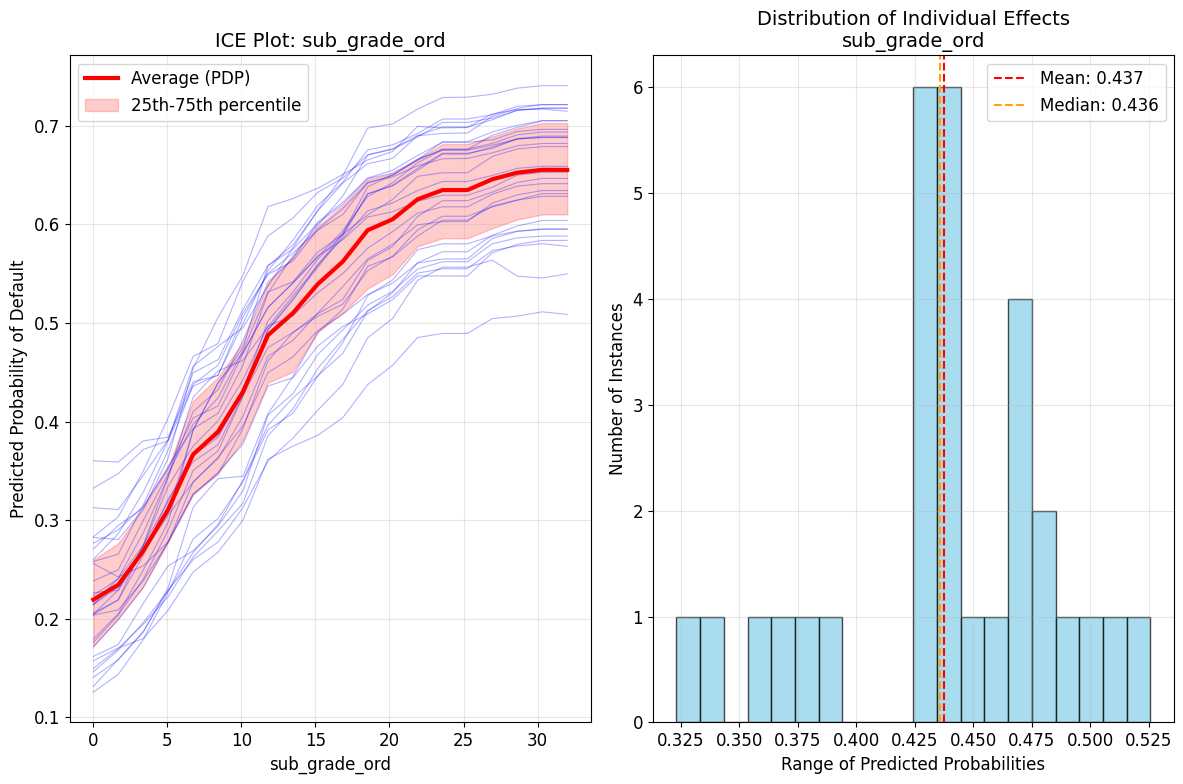


Summary for sub_grade_ord:
  Average effect range: 0.4374
  Max individual effect: 0.5257
  Min individual effect: 0.3232
  Standard deviation: 0.0478

Creating ICE plot for: sub_grade
Creating ICE plot for feature: sub_grade
  Categorical feature with 27 unique values
  Values: ['A1', 'A2', 'A3', 'A4', 'A5']...
  Using 27 grid points
  Analyzing 30 instances

Data types before processing:
  issue_d: float32
  loan_duration: float32
  annual_inc: float32
  avg_cur_bal: float32
  bc_open_to_buy: float32
  bc_util: float32
  delinq_2yrs: float32
  dti: float32
  emp_length: category
  purpose: category
  revol_bal: float32
  revol_util: float32
  sub_grade: category
  tax_liens: float32
  emp_len_years: float32
  sub_grade_ord: float32
  revol_to_inc: float32
  cur_to_openbuy: float32
  log_annual_inc: float32
  dti_clip: float32

Initial modified instance dtypes:
  issue_d: object
  loan_duration: object
  annual_inc: object
  avg_cur_bal: object
  bc_open_to_buy: object
  bc_util: obj

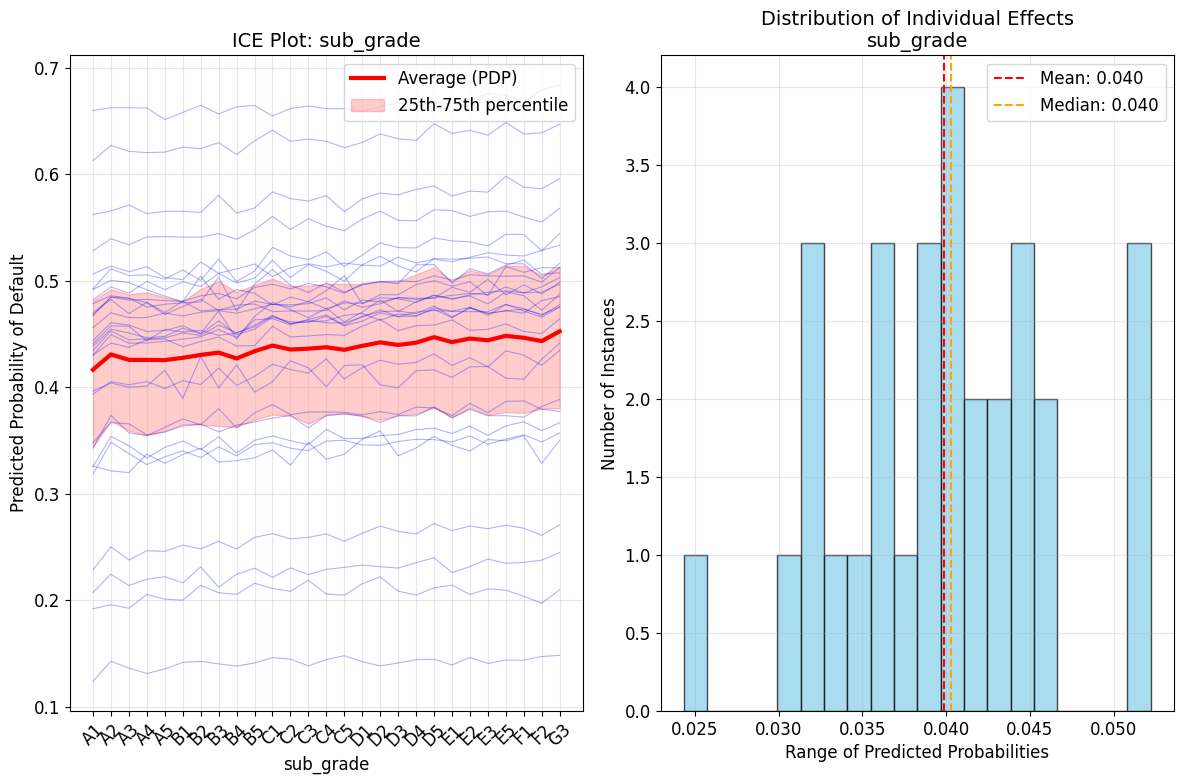


Summary for sub_grade:
  Average effect range: 0.0399
  Max individual effect: 0.0522
  Min individual effect: 0.0244
  Standard deviation: 0.0064

Creating ICE plot for: avg_cur_bal
Creating ICE plot for feature: avg_cur_bal
  Numerical feature range: 238.00 to 71635.00
  Using 20 grid points
  Analyzing 30 instances

Data types before processing:
  issue_d: float32
  loan_duration: float32
  annual_inc: float32
  avg_cur_bal: float32
  bc_open_to_buy: float32
  bc_util: float32
  delinq_2yrs: float32
  dti: float32
  emp_length: category
  purpose: category
  revol_bal: float32
  revol_util: float32
  sub_grade: category
  tax_liens: float32
  emp_len_years: float32
  sub_grade_ord: float32
  revol_to_inc: float32
  cur_to_openbuy: float32
  log_annual_inc: float32
  dti_clip: float32

Initial modified instance dtypes:
  issue_d: object
  loan_duration: object
  annual_inc: object
  avg_cur_bal: object
  bc_open_to_buy: object
  bc_util: object
  delinq_2yrs: object
  dti: object
  

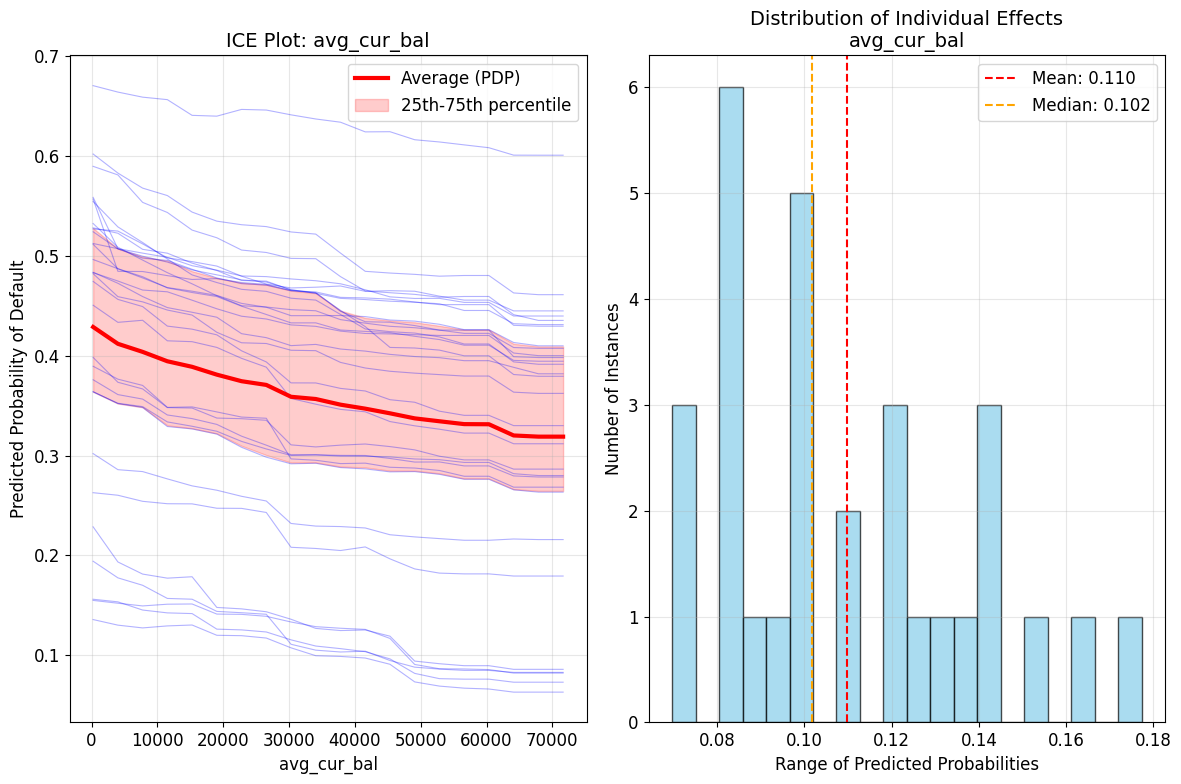


Summary for avg_cur_bal:
  Average effect range: 0.1098
  Max individual effect: 0.1774
  Min individual effect: 0.0696
  Standard deviation: 0.0285

Creating ICE plot for: dti
Creating ICE plot for feature: dti
  Numerical feature range: 1.78 to 40.70
  Using 20 grid points
  Analyzing 30 instances

Data types before processing:
  issue_d: float32
  loan_duration: float32
  annual_inc: float32
  avg_cur_bal: float32
  bc_open_to_buy: float32
  bc_util: float32
  delinq_2yrs: float32
  dti: float32
  emp_length: category
  purpose: category
  revol_bal: float32
  revol_util: float32
  sub_grade: category
  tax_liens: float32
  emp_len_years: float32
  sub_grade_ord: float32
  revol_to_inc: float32
  cur_to_openbuy: float32
  log_annual_inc: float32
  dti_clip: float32

Initial modified instance dtypes:
  issue_d: object
  loan_duration: object
  annual_inc: object
  avg_cur_bal: object
  bc_open_to_buy: object
  bc_util: object
  delinq_2yrs: object
  dti: object
  emp_length: object


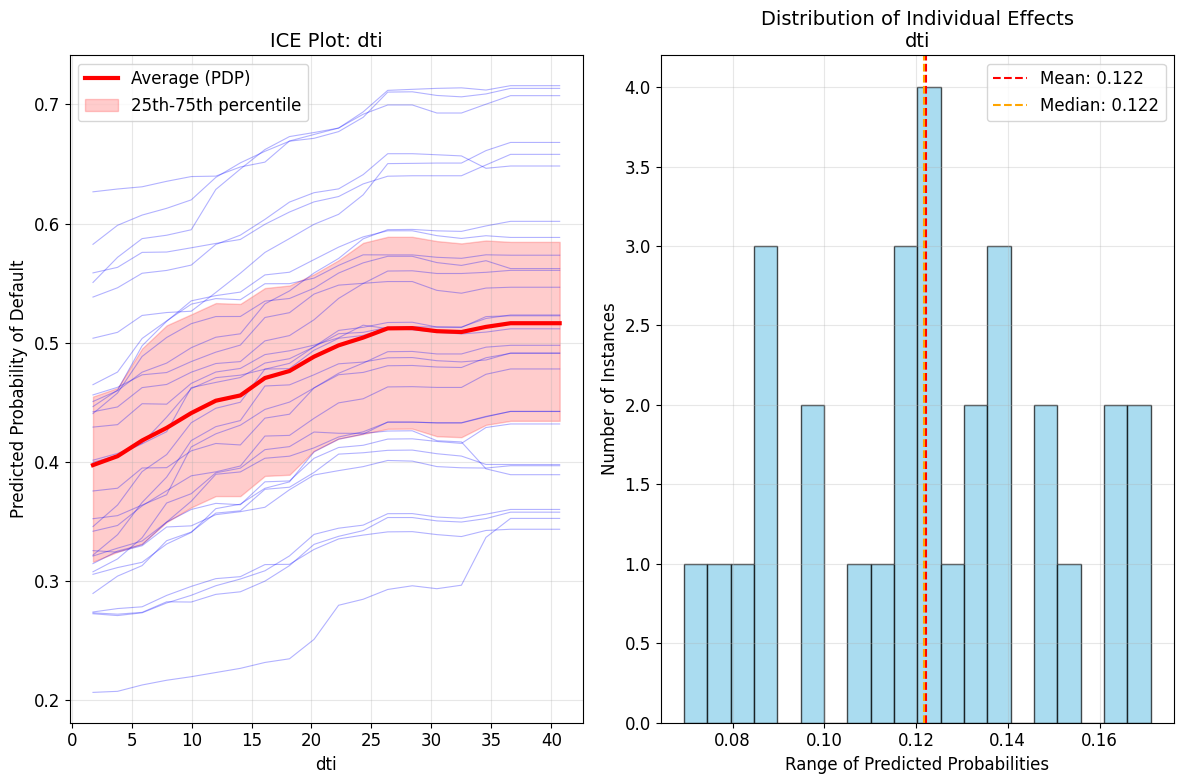


Summary for dti:
  Average effect range: 0.1221
  Max individual effect: 0.1712
  Min individual effect: 0.0694
  Standard deviation: 0.0278

Creating ICE plot for: annual_inc
Creating ICE plot for feature: annual_inc
  Numerical feature range: 7100.00 to 265000.00
  Using 20 grid points
  Analyzing 30 instances

Data types before processing:
  issue_d: float32
  loan_duration: float32
  annual_inc: float32
  avg_cur_bal: float32
  bc_open_to_buy: float32
  bc_util: float32
  delinq_2yrs: float32
  dti: float32
  emp_length: category
  purpose: category
  revol_bal: float32
  revol_util: float32
  sub_grade: category
  tax_liens: float32
  emp_len_years: float32
  sub_grade_ord: float32
  revol_to_inc: float32
  cur_to_openbuy: float32
  log_annual_inc: float32
  dti_clip: float32

Initial modified instance dtypes:
  issue_d: object
  loan_duration: object
  annual_inc: object
  avg_cur_bal: object
  bc_open_to_buy: object
  bc_util: object
  delinq_2yrs: object
  dti: object
  emp_le

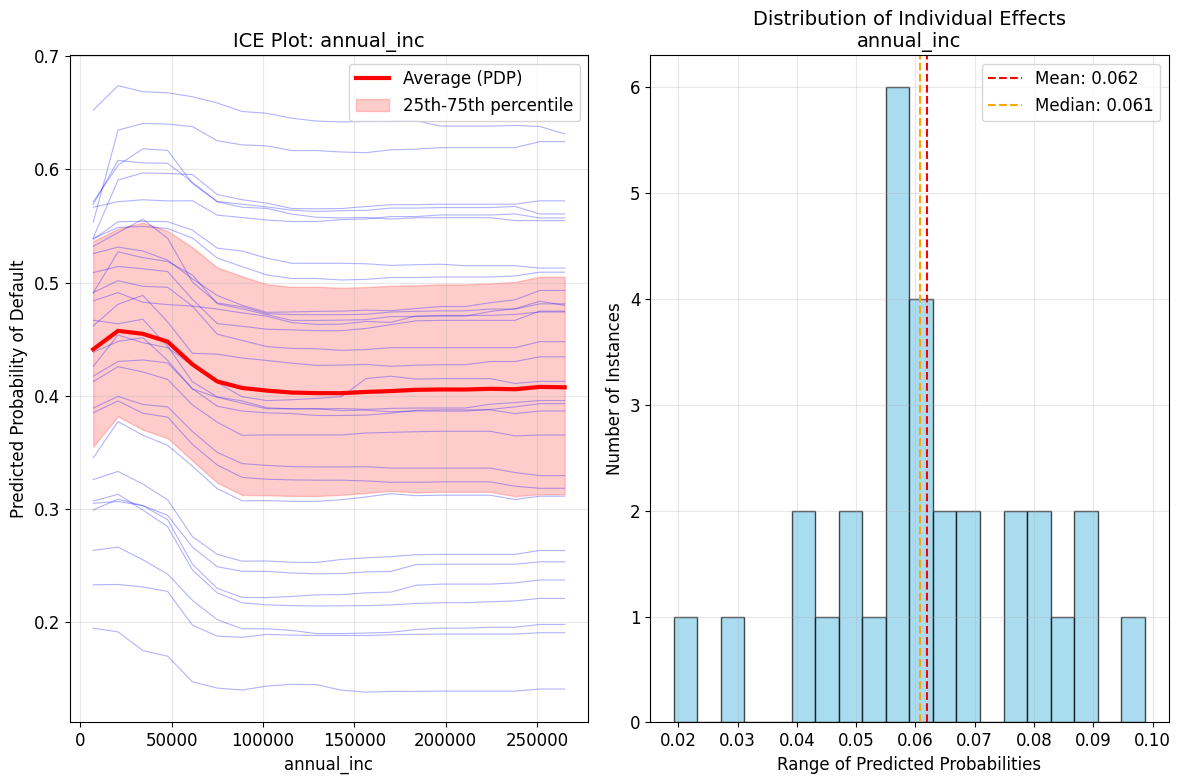


Summary for annual_inc:
  Average effect range: 0.0619
  Max individual effect: 0.0987
  Min individual effect: 0.0192
  Standard deviation: 0.0173

Creating ICE plot for: loan_duration
Creating ICE plot for feature: loan_duration
  Numerical feature range: 0.00 to 1.00
  Using 20 grid points
  Analyzing 30 instances

Data types before processing:
  issue_d: float32
  loan_duration: float32
  annual_inc: float32
  avg_cur_bal: float32
  bc_open_to_buy: float32
  bc_util: float32
  delinq_2yrs: float32
  dti: float32
  emp_length: category
  purpose: category
  revol_bal: float32
  revol_util: float32
  sub_grade: category
  tax_liens: float32
  emp_len_years: float32
  sub_grade_ord: float32
  revol_to_inc: float32
  cur_to_openbuy: float32
  log_annual_inc: float32
  dti_clip: float32

Initial modified instance dtypes:
  issue_d: object
  loan_duration: object
  annual_inc: object
  avg_cur_bal: object
  bc_open_to_buy: object
  bc_util: object
  delinq_2yrs: object
  dti: object
  e

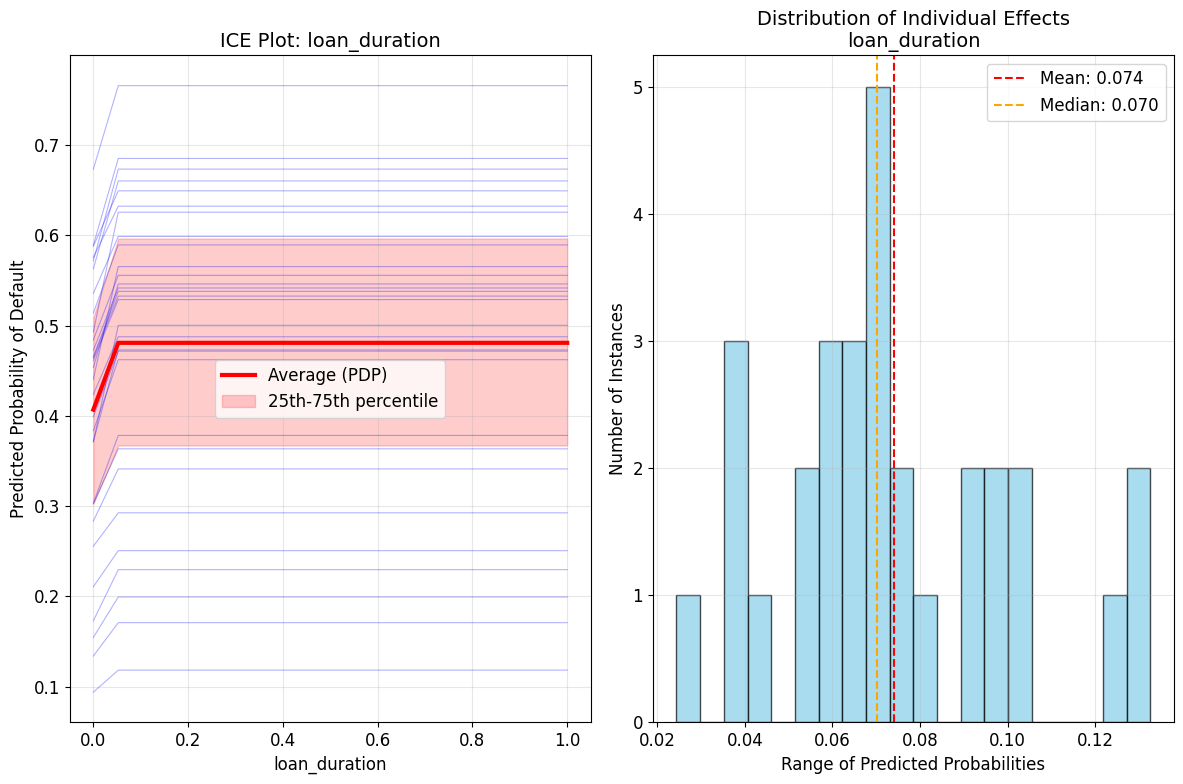


Summary for loan_duration:
  Average effect range: 0.0740
  Max individual effect: 0.1326
  Min individual effect: 0.0244
  Standard deviation: 0.0265

Creating ICE plot for: emp_length
Creating ICE plot for feature: emp_length
  Categorical feature with 11 unique values
  Values: ['1 year', '10+ years', '2 years', '3 years', '4 years']...
  Using 11 grid points
  Analyzing 30 instances

Data types before processing:
  issue_d: float32
  loan_duration: float32
  annual_inc: float32
  avg_cur_bal: float32
  bc_open_to_buy: float32
  bc_util: float32
  delinq_2yrs: float32
  dti: float32
  emp_length: category
  purpose: category
  revol_bal: float32
  revol_util: float32
  sub_grade: category
  tax_liens: float32
  emp_len_years: float32
  sub_grade_ord: float32
  revol_to_inc: float32
  cur_to_openbuy: float32
  log_annual_inc: float32
  dti_clip: float32

Initial modified instance dtypes:
  issue_d: object
  loan_duration: object
  annual_inc: object
  avg_cur_bal: object
  bc_open_t

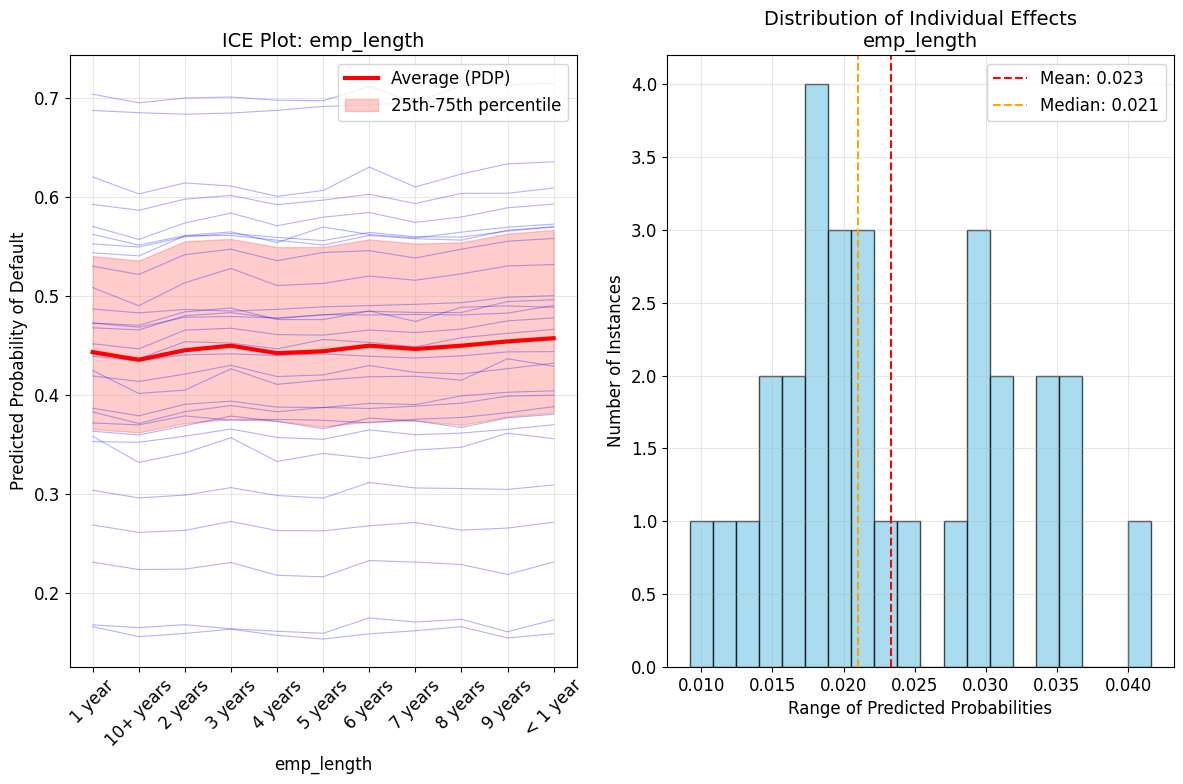


Summary for emp_length:
  Average effect range: 0.0233
  Max individual effect: 0.0416
  Min individual effect: 0.0092
  Standard deviation: 0.0083

ICE ANALYSIS COMPLETED
Successfully analyzed 7 user-specified features:
  1. sub_grade_ord
  2. sub_grade
  3. avg_cur_bal
  4. dti
  5. annual_inc
  6. loan_duration
  7. emp_length

Key Insights from ICE Analysis:
• Each plot shows how individual instances respond to feature changes
• Red line shows the average effect (Partial Dependence)
• Blue lines show individual instance effects
• Wide spread indicates high heterogeneity in feature effects
• Steep slopes indicate strong feature influence on predictions


In [7]:
# ICE IMPLEMENTATION
# Individual Conditional Expectation Plots

print("\n" + "=" * 60)
print("ICE (Individual Conditional Expectation) Plots")
print("=" * 60)
print("""
ICE plots show how predictions change for individual instances when we vary 
a single feature while keeping all other features constant.

Key advantages:
- Shows heterogeneity in feature effects across instances
- Reveals non-linear relationships and interactions
- Helps understand model behavior at the individual level
- Complements global feature importance measures

ICE vs PDP:
- PDP (Partial Dependence Plot): Shows average effect across all instances
- ICE: Shows effect for each individual instance separately
""")

def create_ice_plot(model, X_data, feature_name, num_ice_lines=50, num_grid_points=20, figsize=(12, 8)):
    """
    Create ICE plot for a specific feature
    """
    print(f"Creating ICE plot for feature: {feature_name}")
    
    # Sample instances for ICE lines to avoid overcrowding
    if len(X_data) > num_ice_lines:
        sample_indices = np.random.choice(len(X_data), num_ice_lines, replace=False)
        sample_data = X_data.iloc[sample_indices].copy()
    else:
        sample_data = X_data.copy()
    
    # Handle categorical features
    is_categorical = X_data[feature_name].dtype.name in ('object', 'category')
    
    if is_categorical:
        # For categorical features, use unique values
        feature_values = sorted(X_data[feature_name].unique())
        print(f"  Categorical feature with {len(feature_values)} unique values")
        print(f"  Values: {feature_values[:5]}...")
    else:
        # For numerical features, get range and create grid
        feature_min = X_data[feature_name].min()
        feature_max = X_data[feature_name].max()
        feature_values = np.linspace(feature_min, feature_max, num_grid_points)
        print(f"  Numerical feature range: {feature_min:.2f} to {feature_max:.2f}")
    
    print(f"  Using {len(feature_values)} grid points")
    print(f"  Analyzing {len(sample_data)} instances")
    
    # Store predictions for each instance
    ice_predictions = []
    
    # Identify categorical and numeric columns
    categorical_cols = [col for col in X_data.columns if X_data[col].dtype.name in ('object', 'category')]
    numeric_cols = [col for col in X_data.columns if col not in categorical_cols]
    
    # Debug: Print data types
    print("\nData types before processing:")
    for col in X_data.columns:
        print(f"  {col}: {X_data[col].dtype}")
    
    for idx, (_, instance) in enumerate(sample_data.iterrows()):
        instance_predictions = []
        
        for feature_val in feature_values:
            try:
                # Create modified instance as DataFrame (not array) to preserve dtypes
                modified_instance = instance.to_frame().T.copy()
                
                # Debug: Print initial dtypes
                if idx == 0 and feature_val == feature_values[0]:
                    print("\nInitial modified instance dtypes:")
                    for col in modified_instance.columns:
                        print(f"  {col}: {modified_instance[col].dtype}")
                
                # Ensure proper dtypes for all columns
                for col in categorical_cols:
                    if col == feature_name and is_categorical:
                        # For the target feature, use the new value
                        modified_instance[col] = pd.Categorical([feature_val], 
                                                              categories=X_data[col].cat.categories)
                    else:
                        # For other categorical features, preserve the original value and dtype
                        modified_instance[col] = pd.Categorical(modified_instance[col], 
                                                              categories=X_data[col].cat.categories)
                
                # Handle numeric columns
                for col in numeric_cols:
                    if col == feature_name and not is_categorical:
                        # For the target feature, use the new value
                        modified_instance[col] = feature_val
                    # Always ensure numeric dtype
                    modified_instance[col] = modified_instance[col].astype(X_data[col].dtype)
                
                # Debug: Print final dtypes
                if idx == 0 and feature_val == feature_values[0]:
                    print("\nFinal modified instance dtypes:")
                    for col in modified_instance.columns:
                        print(f"  {col}: {modified_instance[col].dtype}")
                    print("\nSample row:")
                    print(modified_instance)
                
                # Get prediction using DataFrame (not array)
                pred = model.predict(modified_instance)[0]
                instance_predictions.append(pred)
                
            except Exception as e:
                print(f"\nError processing instance {idx}, feature value {feature_val}:")
                print(f"Error type: {type(e).__name__}")
                print(f"Error message: {str(e)}")
                raise
        
        ice_predictions.append(instance_predictions)
        
        if (idx + 1) % 10 == 0:
            print(f"  Processed {idx + 1}/{len(sample_data)} instances")
    
    # Create the plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Left plot: ICE lines
    ice_array = np.array(ice_predictions)
    
    # Plot individual ICE lines
    for i, predictions in enumerate(ice_predictions):
        ax1.plot(feature_values, predictions, alpha=0.3, color='blue', linewidth=0.8)
    
    # Plot average (PDP line)
    avg_predictions = np.mean(ice_predictions, axis=0)
    ax1.plot(feature_values, avg_predictions, color='red', linewidth=3, label='Average (PDP)')
    
    # Add percentile bands
    p25 = np.percentile(ice_array, 25, axis=0)
    p75 = np.percentile(ice_array, 75, axis=0)
    ax1.fill_between(feature_values, p25, p75, alpha=0.2, color='red', label='25th-75th percentile')
    
    ax1.set_title(f'ICE Plot: {feature_name}', fontsize=14)
    ax1.set_xlabel(feature_name, fontsize=12)
    ax1.set_ylabel('Predicted Probability of Default', fontsize=12)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    if is_categorical:
        ax1.set_xticks(range(len(feature_values)))
        ax1.set_xticklabels(feature_values, rotation=45)
    
    # Right plot: Distribution of feature effects
    # Calculate the range of predictions for each instance
    ice_ranges = [max(preds) - min(preds) for preds in ice_predictions]
    
    ax2.hist(ice_ranges, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    ax2.set_title(f'Distribution of Individual Effects\n{feature_name}', fontsize=14)
    ax2.set_xlabel('Range of Predicted Probabilities', fontsize=12)
    ax2.set_ylabel('Number of Instances', fontsize=12)
    ax2.grid(True, alpha=0.3)
    
    # Add statistics
    mean_range = np.mean(ice_ranges)
    median_range = np.median(ice_ranges)
    ax2.axvline(mean_range, color='red', linestyle='--', label=f'Mean: {mean_range:.3f}')
    ax2.axvline(median_range, color='orange', linestyle='--', label=f'Median: {median_range:.3f}')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    return {
        'feature_values': feature_values,
        'ice_predictions': ice_predictions,
        'avg_predictions': avg_predictions,
        'ice_ranges': ice_ranges,
        'is_categorical': is_categorical
    }

# Get feature importance to select most important features for ICE plots
feature_importance = model.feature_importance(importance_type='gain')
importance_df = pd.DataFrame({
    'feature': list(X_test.columns),
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print(f"\nFeature Importance (Top 10):")
print(importance_df.head(10).to_string(index=False))

# SPECIFIC FEATURES FOR ICE ANALYSIS (AS REQUESTED)
print("\nSelecting specific features for ICE plots...")

# User-specified features for ICE analysis
selected_features = [
    'sub_grade_ord',    # Ordinal encoding of sub_grade
    'sub_grade',        # Original categorical sub_grade  
    'avg_cur_bal',      # Average current balance
    'dti',              # Debt-to-income ratio
    'annual_inc',       # Annual income
    'loan_duration',    # Loan duration
    'emp_length'        # Employment length (categorical)
]

print(f"Selected features for ICE analysis: {selected_features}")

# Verify all requested features exist in the dataset
print(f"\nVerifying requested features exist in dataset:")
available_features = []
missing_features = []

for feature in selected_features:
    if feature in X_test.columns:
        available_features.append(feature)
        print(f"  ✓ {feature}: Available")
        print(f"    Data type: {X_test[feature].dtype}")
        print(f"    Sample values: {X_test[feature].head(3).tolist()}")
        if X_test[feature].dtype.name in ('object', 'category'):
            unique_vals = X_test[feature].nunique()
            print(f"    Unique categories: {unique_vals}")
            if unique_vals <= 10:
                print(f"    Categories: {sorted(X_test[feature].unique())}")
    else:
        missing_features.append(feature)
        print(f"  ❌ {feature}: NOT FOUND in dataset")

print(f"\nSummary:")
print(f"  Available features: {len(available_features)}")
print(f"  Missing features: {len(missing_features)}")

if missing_features:
    print(f"  Missing: {missing_features}")
    print(f"  Available columns in dataset: {list(X_test.columns)}")

# Use only available features for ICE analysis
selected_features = available_features
print(f"\nProceeding with {len(selected_features)} available features for ICE analysis:")

# Display final selected features with detailed information
print(f"\nFinal selected features for ICE analysis:")
for i, feature in enumerate(selected_features, 1):
    print(f"  {i}. {feature}")
    print(f"     Type: {X_test[feature].dtype}")
    print(f"     Range: {X_test[feature].min()} to {X_test[feature].max()}" if X_test[feature].dtype.kind in 'biufc' else f"     Categories: {X_test[feature].nunique()}")
    
    # Get feature importance if available
    if feature in importance_df['feature'].values:
        importance = importance_df[importance_df['feature'] == feature]['importance'].iloc[0]
        print(f"     Importance: {importance:.4f}")
    else:
        print(f"     Importance: Not in top features")
    print()

# Create ICE plots
ice_results = {}
for feature in selected_features:
    print(f"\n{'='*50}")
    print(f"Creating ICE plot for: {feature}")
    print(f"{'='*50}")
    
    ice_data = create_ice_plot(model, X_test.head(200), feature, num_ice_lines=30)
    ice_results[feature] = ice_data
    
    # Print summary statistics
    print(f"\nSummary for {feature}:")
    print(f"  Average effect range: {np.mean(ice_data['ice_ranges']):.4f}")
    print(f"  Max individual effect: {max(ice_data['ice_ranges']):.4f}")
    print(f"  Min individual effect: {min(ice_data['ice_ranges']):.4f}")
    print(f"  Standard deviation: {np.std(ice_data['ice_ranges']):.4f}")

print(f"\n" + "="*70)
print(f"ICE ANALYSIS COMPLETED")
print(f"="*70)
print(f"Successfully analyzed {len(selected_features)} user-specified features:")
for i, feature in enumerate(selected_features, 1):
    print(f"  {i}. {feature}")

print(f"\nKey Insights from ICE Analysis:")
print(f"• Each plot shows how individual instances respond to feature changes")
print(f"• Red line shows the average effect (Partial Dependence)")
print(f"• Blue lines show individual instance effects")
print(f"• Wide spread indicates high heterogeneity in feature effects")
print(f"• Steep slopes indicate strong feature influence on predictions")


In [13]:
# Save summary statistics
summary_stats = {
    'model_performance': {
        'test_auc': float(roc_auc_score(y_test, test_probs)),
        'num_features': len(X_test.columns),
        'num_instances_analyzed': len(selected_indices)
    },
    'lime_analysis': {
        'num_explanations': len(lime_explanations),
        'avg_features_per_explanation': np.mean([len(exp[1].as_list(label=1)) for exp in lime_explanations])
    },
    'ice_analysis': {
        'num_features_analyzed': len(ice_results),
        'avg_effect_range': np.mean([np.mean(data['ice_ranges']) for data in ice_results.values()])
    },
    'top_features': {
        'global_importance': importance_df.head(5)['feature'].tolist(),
        'analyzed_by_both_methods': len(set(ice_results.keys()).intersection(
            set([feat.split('=')[0].strip() for _, exp in lime_explanations 
                 for feat, _ in exp.as_list(label=1)])))
    }
}

print(f"\nSUMMARY STATISTICS:")
print(f"  Model AUC: {summary_stats['model_performance']['test_auc']:.4f}")
print(f"  Features analyzed: {summary_stats['model_performance']['num_features']}")
print(f"  LIME explanations: {summary_stats['lime_analysis']['num_explanations']}")
print(f"  ICE plots created: {summary_stats['ice_analysis']['num_features_analyzed']}")


SUMMARY STATISTICS:
  Model AUC: 0.6868
  Features analyzed: 20
  LIME explanations: 5
  ICE plots created: 7
